# Prétraitement des images en appliquant un masque autour des cellules

In [1]:
import os
import glob
import random
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import cv2
import numpy as np

In [2]:
# --- Configuration ---
# Chemin vers le répertoire contenant les dossiers des types de cellules
data_path = "/home/anthony-sauvage/repo/BloodCellClassification/app/data/raw/bloodcells_dataset"
def get_image_path(dataset_map, subdir_name: str, index_img: int):
    list_img = dataset_map[subdir_name]
    img_path = os.path.join(data_path, f"{subdir_name}/{list_img[index_img]}")
    #print(img_path)
    return img_path

def map_subdirs_to_files(dir_path):
    """
    Crée un dictionnaire qui mappe directement chaque nom de sous-répertoire
    à la liste de ses fichiers (images).

    Format de sortie :
    {
        "nom_sous_repertoire_1": ["img1.jpg", "img2.jpg"],
        "nom_sous_repertoire_2": ["imgA.jpg", "imgB.jpg"],
        ...
    }

    Args:
        dir_path (str): Le chemin vers le répertoire principal.

    Returns:
        dict: Un dictionnaire où les clés sont les noms des sous-répertoires
              et les valeurs sont les listes de noms de fichiers.
              Retourne un dictionnaire vide si le chemin n'est pas un répertoire valide ou est vide.
    """
    direct_mapping = {}
    if not os.path.isdir(dir_path):
        print(f"Le chemin '{dir_path}' n'est pas un répertoire valide.")
        return direct_mapping

    for item_name in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item_name)
        
        # On s'assure que c'est bien un sous-répertoire
        if os.path.isdir(item_path):
            # Liste uniquement les fichiers dans chaque sous-répertoire
            files_in_subdir = [f for f in os.listdir(item_path) if os.path.isfile(os.path.join(item_path, f))]
            direct_mapping[item_name] = files_in_subdir # Le nom du sous-répertoire est la clé
            
    return direct_mapping

dataset_map = map_subdirs_to_files(data_path)

# Chargement de l'image JPG

In [3]:

# Méthode 1: Avec OpenCV (recommandée)
def load_image_opencv(image_path):
    image = cv2.imread(image_path)  # Charge en BGR
    return image

# Méthode 2: Avec PIL/Pillow puis conversion
from PIL import Image
def load_image_pil(image_path):
    pil_image = Image.open(image_path)
    image = np.array(pil_image)
    # Convertir RGB vers BGR pour OpenCV
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image

# Cell mask

## Approche par seuillage adaptatif 
Cette méthode exploite le fait que les cellules sont généralement plus sombres que le fond :

In [21]:
def create_adaptive_mask(image):
    # Conversion en niveaux de gris si nécessaire
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Seuillage adaptatif pour détecter les zones sombres
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 15, 2)
    
    # Trouver les contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sélectionner le contour le plus proche du centre
    center = (image.shape[1]//2, image.shape[0]//2)
    best_contour = min(contours, key=lambda c: cv2.pointPolygonTest(c, center, True)**2)
    
    # Créer le masque
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [best_contour], 255)
    
    return mask

# Approche par détection de cercles (pour les cellules rondes)
Utilise la transformée de Hough pour détecter les cellules circulaires :

In [5]:
def create_circle_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Détection de cercles
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=30,
                              param1=50, param2=30, minRadius=10, maxRadius=100)
    
    mask = np.zeros(gray.shape, dtype=np.uint8)
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        # Prendre le cercle le plus proche du centre
        center = (image.shape[1]//2, image.shape[0]//2)
        distances = [np.sqrt((x-center[0])**2 + (y-center[1])**2) for x, y, r in circles]
        best_circle = circles[np.argmin(distances)]
        
        cv2.circle(mask, (best_circle[0], best_circle[1]), best_circle[2], 255, -1)
    
    return mask

##  Approche hybride (la plus robuste)
Combine plusieurs techniques pour gérer tous les types de cellules :

In [52]:
def create_robust_mask(image):
    # Essayer d'abord la détection de cercles
    #circle_mask = create_circle_mask(image)
    circle_mask = create_adaptive_circle_mask(image)
    
    # Si aucun cercle détecté, utiliser le seuillage adaptatif
    if np.sum(circle_mask) == 0:
        return create_adaptive_mask(image)
    
    # Sinon, combiner avec le seuillage pour affiner
    adaptive_mask = create_adaptive_mask(image)
    
    # Intersection des deux masques
    #combined_mask = cv2.bitwise_and(circle_mask, adaptive_mask)
    
    # Union des deux masques
    combined_mask = cv2.bitwise_or(circle_mask, adaptive_mask)
    
    # Si l'intersection est trop petite, utiliser le masque adaptatif
    if np.sum(combined_mask) < np.sum(adaptive_mask) * 0.5:
        return adaptive_mask
    
    return combined_mask

Détection automatique de la taille optimale

In [35]:
def create_adaptive_circle_mask(image):
    """
    Détecte automatiquement la taille optimale du cercle basée sur la cellule
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # D'abord, obtenir une estimation grossière avec le seuillage adaptatif
    adaptive_mask = create_adaptive_mask(image)
    
    if np.sum(adaptive_mask) == 0:
        return adaptive_mask
    
    # Trouver le contour principal
    contours, _ = cv2.findContours(adaptive_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return adaptive_mask
    
    # Prendre le plus grand contour
    main_contour = max(contours, key=cv2.contourArea)
    
    # Calculer le cercle englobant minimal
    (x, y), radius = cv2.minEnclosingCircle(main_contour)
    center = (int(x), int(y))
    radius = int(radius * 1.2)  # Agrandir de 20%
    
    # Créer le masque circulaire optimisé
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)
    
    return mask

## Post-traitement
Pour améliorer la qualité du masque :

In [7]:
def refine_mask(mask):
    # Opérations morphologiques pour nettoyer le masque
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Fermeture pour combler les trous
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Ouverture pour supprimer le bruit
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Remplissage des trous internes
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.fillPoly(mask, contours, 255)
    
    return mask

# Pipeline pour créer des masques autour des cellules

In [62]:

def create_adaptive_mask(image):
    """
    image: array NumPy de forme (height, width, 3) pour une image couleur
           ou (height, width) pour une image en niveaux de gris
    """
    # Conversion en niveaux de gris si nécessaire
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Seuillage adaptatif pour détecter les zones sombres
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 15, 2)
    
    # Trouver les contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return np.zeros(gray.shape, dtype=np.uint8)
    
    # Sélectionner le contour le plus proche du centre
    center = (image.shape[1]//2, image.shape[0]//2)
    best_contour = min(contours, key=lambda c: abs(cv2.pointPolygonTest(c, center, True)))
    
    # Créer le masque
    mask = np.zeros(gray.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [best_contour], 255)
    
    return mask

def apply_mask_to_image(image, mask):
    """Applique le masque à l'image (met les pixels du fond à 0)"""
    if len(image.shape) == 3:
        # Image couleur
        masked_image = image.copy()
        masked_image[mask == 0] = [0, 0, 0]  # Fond noir
    else:
        # Image en niveaux de gris
        masked_image = image.copy()
        masked_image[mask == 0] = 0
    
    return masked_image

# Exemple d'utilisation complète
def process_cell_image(image_path):
    # 1. Charger l'image JPG
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Erreur: impossible de charger l'image {image_path}")
        return None
    
    # 2. Créer le masque
    # mask = create_adaptive_mask(image)
    # mask = create_circle_mask(image)
    #mask = create_robust_mask(image)
    mask = create_adaptive_circle_mask(image)
    #mask = refine_mask(mask)
    # 3. Appliquer le masque
    masked_image = apply_mask_to_image(image, mask)
    
    return masked_image, mask

# Utilisation
image_path = get_image_path(dataset_map, 'ig', index_img=0)
masked_image, mask = process_cell_image(image_path)

# Sauvegarder le résultat
if masked_image is not None:
    cv2.imwrite("mask/circle_cellule_masquee.jpg", masked_image)
    cv2.imwrite("mask/circle_masque.jpg", mask)


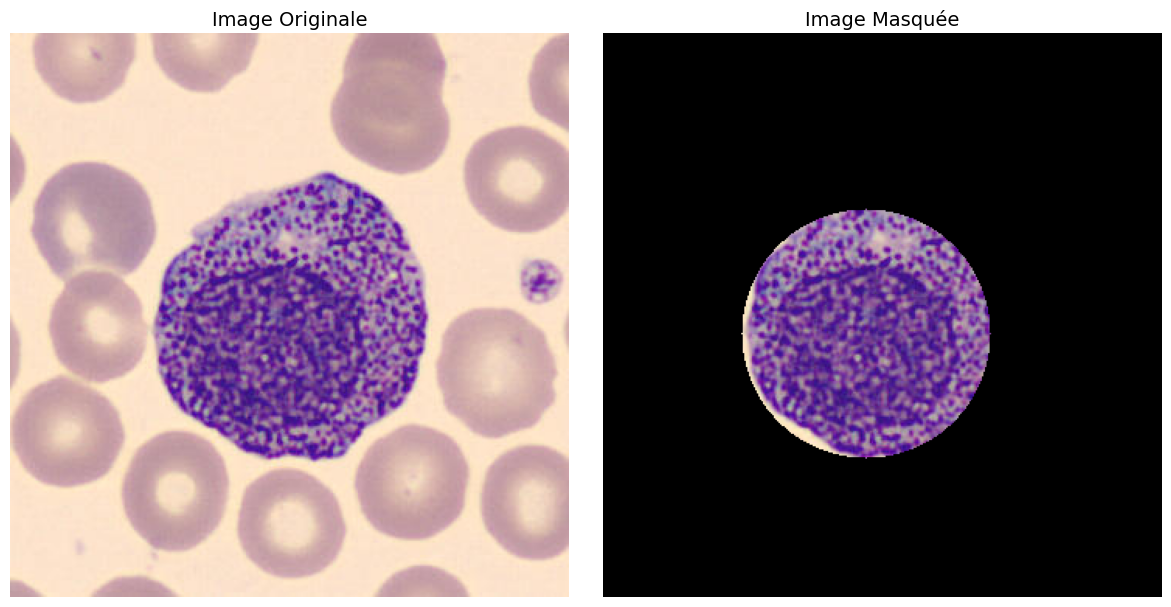

In [63]:
def display_before_after(image_path, figsize=(12, 6)):
    """
    Affiche l'image originale et l'image masquée côte à côte
    
    Args:
        image_path: chemin vers l'image JPG
        figsize: taille de la figure (largeur, hauteur)
    """
    # Traiter l'image
    masked_image, mask = process_cell_image(image_path)
    
    if masked_image is None:
        print(f"Erreur: impossible de traiter l'image {image_path}")
        return
    
    # Charger l'image originale
    original_image = cv2.imread(image_path)
    
    # Convertir BGR vers RGB pour matplotlib
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    
    # Créer la figure avec 2 sous-graphiques
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Image originale
    axes[0].imshow(original_rgb)
    axes[0].set_title('Image Originale', fontsize=14)
    axes[0].axis('off')
    
    # Image masquée
    axes[1].imshow(masked_rgb)
    axes[1].set_title('Image Masquée', fontsize=14)
    axes[1].axis('off')
    
    # Ajuster l'espacement
    plt.tight_layout()
    plt.show()

image_path = get_image_path(dataset_map, 'ig', index_img=10)    
display_before_after(image_path, figsize=(12, 6))

## Pour traiter plusieurs images

In [ ]:
import os
import glob

def process_multiple_images(input_folder, output_folder):
    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(output_folder, exist_ok=True)
    
    # Traiter tous les fichiers JPG
    for image_path in glob.glob(os.path.join(input_folder, "*.jpg")):
        filename = os.path.basename(image_path)
        name, ext = os.path.splitext(filename)
        
        # Traiter l'image
        masked_image, mask = process_cell_image(image_path)
        
        if masked_image is not None:
            # Sauvegarder l'image masquée
            output_path = os.path.join(output_folder, f"{name}_masked{ext}")
            cv2.imwrite(output_path, masked_image)
            
            # Optionnel: sauvegarder aussi le masque
            mask_path = os.path.join(output_folder, f"{name}_mask{ext}")
            cv2.imwrite(mask_path, mask)

# Utilisation
process_multiple_images("dossier_images_originales", "dossier_images_masquees")